In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
from PIL import Image
%matplotlib inline

# 辞書の探求

#### ランダムな辞書を生成

In [3]:
A0 = np.random.randn(30, 60) ## 次元数 30, 辞書数60
A0 = A0 @ np.diag(1 / np.sqrt(np.diag(A0.T @ A0)))

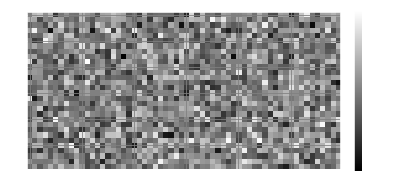

In [4]:
plt.imshow(A0, cmap='gray', interpolation='Nearest')
plt.colorbar(fraction=0.024, pad=0.04)

#### 信号事例を生成

In [5]:
y = np.zeros((30, 4000)) ## 次元数30, データ数4000
sig = 0.1
k0 = 4
for i in range(4000):
    y[:,i] = A0[:, np.random.permutation(range(60))[:k0]] @ np.random.randn(k0) + np.random.randn(30)*sig

<BarContainer object of 30 artists>

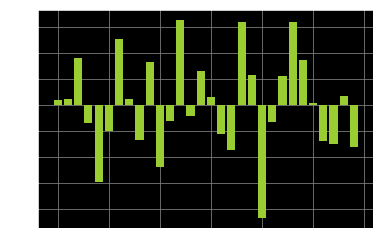

In [6]:
plt.bar(range(30), y[:,1])

In [7]:
def OMP(X, y, k0=4, tol=1e-4):

    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    theta = np.zeros([X.shape[1],1])
    
    S = np.zeros(X.shape[1], dtype=np.uint8)
    r = y.copy()
    rr = r.T @ r
    for _ in range(k0):
        err = rr - (X[:, S==0].T @ r)**2
        ndx = np.where(S==0)[0]
        S[ndx[err.argmin()]] = 1
        Xs = X[:, S==1]
        pinv = np.linalg.pinv(Xs @ Xs.T)
        theta[S==1] = (Xs.T @ (pinv @ y)).reshape(-1,1)
        r = y - (X @ theta)
        rr = r.T @ r
        if rr < tol:
            break
    
    return theta.flatten(), S

In [8]:
def percent_recovery_of_atoms(A, A0, threshold=0.99):
    """ アトムの復元率を測る """
    num = 0
    for m in range(A.shape[1]):
        a = A0[:, m]
        if np.abs(np.dot(a, A)).max() > threshold:
            num += 1
    return float(num) / A.shape[1] * 100

In [9]:
def MOD(X, y, D, k0, tol=1e-4, n_iter=50, D0=None):
    log = []
    for n in range(n_iter):
        print("ITERATION: [{}]".format(n))
        print("START OMP")
        for i in range(y.shape[1]): ## データごとに処理
            X[:,i], _ = OMP(D, y[:,i], k0=k0, tol=tol)
        print("FINISH OMP")
        opt = np.abs( y - D @ X).mean()
        print("START TO CALCURATE INVERSE MATRIX")
        XXTinv = np.linalg.pinv(X@X.T)
        print("FINISH CALCURATE INVERSE MATRIX")
        D = y @ (X.T @ XXTinv)
        D = D @ np.diag(1.0 / np.sqrt(np.diag(D.T @ D))) ## 正規化
        
        if D0 is not None:
            opt2 = percent_recovery_of_atoms(D, D0)
            log.append((opt, opt2))
        else:
            log.append(opt)
        print(n, log[n])
    
    return D, np.array(log)
        

In [10]:
D = y[:, :A0.shape[1]]
D = D @ np.diag(1.0 / np.sqrt(np.diag( D.T @ D)))
X = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数

In [11]:
A_MOD, log_MOD = MOD(X, y, D, k0=k0, D0=A0)

ITERATION: [0]
START OMP
FINISH OMP
START TO CALCURATE INVERSE MATRIX
FINISH CALCURATE INVERSE MATRIX
0 (0.1555974619994217, 0.0)
ITERATION: [1]
START OMP


KeyboardInterrupt: 

Text(0.5,0,'iteration')

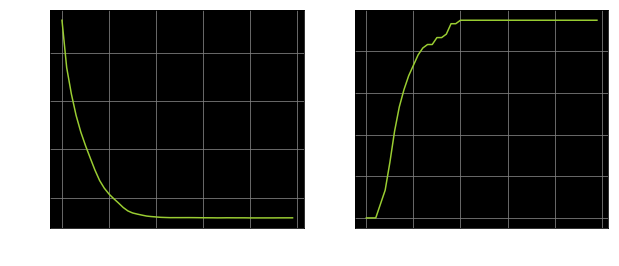

In [288]:
figs, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(log_MOD[:,0])
axs[0].set_ylabel("average error")
axs[0].set_xlabel("iteration")
axs[1].plot(log_MOD[:,1])
axs[1].set_ylabel("correct atom ratio")
axs[1].set_xlabel("iteration")


In [247]:
X0 = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数
for i in range(Y.shape[1]): ## データごとに処理
    X0[:,i], _ = OMP(A_MOD, y[:,i], k0=k0, tol=1e-4)

In [277]:
from sklearn.linear_model import Lasso
X1 = np.zeros([D.shape[1], y.shape[1]]) ## 辞書数 x データ数
lasso = Lasso(alpha=0.005, max_iter=1000, tol=1e-4)
for i in range(Y.shape[1]): ## データごとに処理
    lasso.fit(A_MOD, y[:,i])
    X1[:,i] = lasso.coef_

In [278]:
y_pred0 = A_MOD @ X0
y_pred1 = A_MOD @ X1

In [279]:
err0 = np.mean((y - y_pred0)**2, axis=0)
err1 = np.mean((y - y_pred1)**2, axis=0)

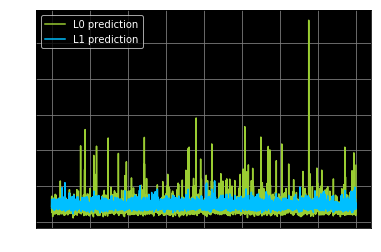

In [280]:
plt.plot(err0, label="L0 prediction")
plt.plot(err1, label="L1 prediction")
plt.legend()

In [282]:
print("L0 predction error = {}".format(np.mean(err0)))
print("L1 predction error = {}".format(np.mean(err1)))

L0 predction error = 0.00830222618563305
L1 predction error = 0.009243158522852492


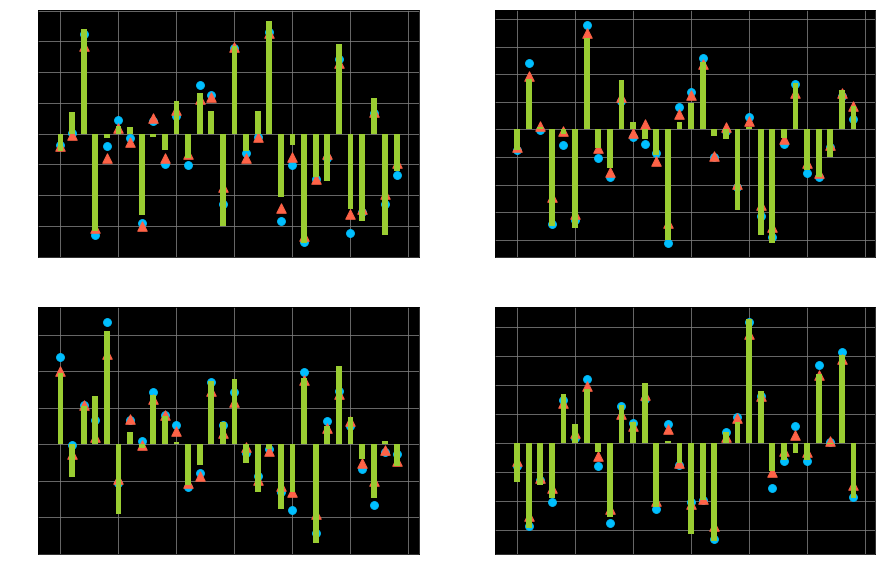

In [286]:
idxs = np.random.permutation(4000)[:4]
figs, axs = plt.subplots(2,2,figsize=(15,10))
for i in range(2):
    for j in range(2):
        axs[i][j].bar(range(30), y[:, idxs[2*i+j]], width=0.5)
        axs[i][j].scatter(range(30), y_pred0[:,idxs[2*i+j]], marker="o", s=60)
        axs[i][j].scatter(range(30), y_pred1[:,idxs[2*i+j]], marker="^", s=90)

# 画像で辞書を評価

In [19]:
im = np.asarray(Image.open("./barbara.png"))

([], <a list of 0 Text yticklabel objects>)

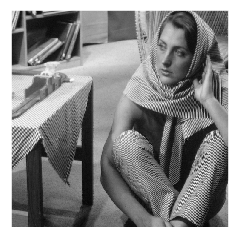

In [20]:
plt.imshow(im, cmap='gray')
plt.xticks([])
plt.yticks([])

### 2次元DCT基底辞書作成

In [21]:
k = 10
size = 8
num = 11

In [22]:
def getDCTImage(size, num):
    A_1D = np.zeros((size,num))
    for k in np.arange(num):
        for i in np.arange(size):
            A_1D[i,k] = np.cos(i * k * np.pi / num)
        if k != 0:
            A_1D[:,k] -= A_1D[:,k].mean()

    A_2D = np.kron(A_1D, A_1D)
    n, m = int(np.sqrt(A_2D.shape[0])), int(np.sqrt(A_2D.shape[1]))
    A_2Dr = A_2D.reshape((n,n,m,m))
    
    return A_2Dr

In [23]:
def getDCTImage2(size, num):
    basicImage = []
    for k in range(11):
        dct_img =  np.array([np.cos(i*k*np.pi / num) for i in range(size)]).repeat(size).reshape(size,size)
        dct_img -= dct_img.mean()
        basicImage.append(dct_img)
    
    DCT2D = np.zeros([size, size, num, num])
    for i in range(num):
        for j in range(num):
            if i==0:
                DCT2D[:,:,i,j] = basicImage[j].T
            elif j==0:
                DCT2D[:,:,i,j] = basicImage[i]
            else:
                DCT2D[:,:,i,j] = basicImage[i] @ basicImage[j].T
    return DCT2D        

In [24]:
DCT2D = getDCTImage2(size, num)

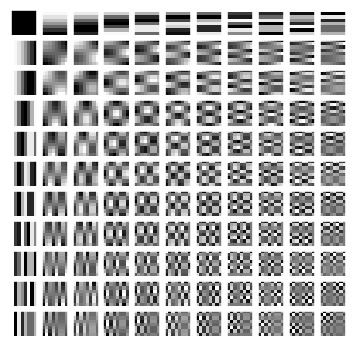

In [16]:
figs, axs = plt.subplots(num,num,figsize=(6,6))
for row in range(num):
    for col in range(num):
        axs[row][col].imshow(DCT2D[:,:,col,row], cmap='gray')
        axs[row][col].set_xticks([])
        axs[row][col].set_yticks([])

### 画像のパッチ抽出

In [25]:
img_patchs = []
patch_size = 8
for row in range(im.shape[0] - patch_size + 1):
    for col in range(im.shape[1] - patch_size + 1):
        img_patchs.append(im[row:row+patch_size, col:col+patch_size])
img_patchs = np.array(img_patchs)

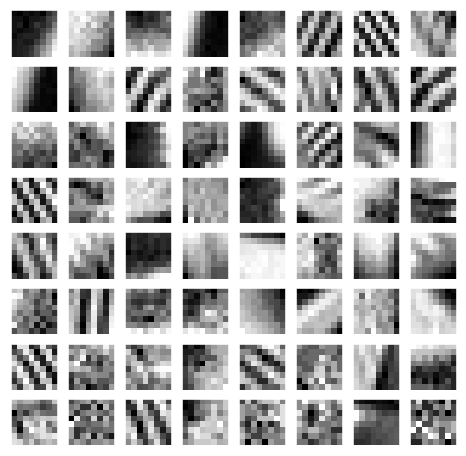

In [26]:
# patch の一部を描画
pick_id = np.random.permutation(img_patchs.shape[0])[:patch_size**2]
img_patchs_pick = img_patchs[pick_id,:,:]
img_patchs_pick.shape
figs, axs = plt.subplots(patch_size, patch_size, figsize=(patch_size, patch_size))
for row in range(patch_size):
    for col in range(patch_size):
        axs[row][col].imshow(img_patchs_pick[patch_size * row + col, :, :], cmap='gray')
        axs[row][col].set_xticks([])
        axs[row][col].set_yticks([])

In [27]:
img_patchs_pick = img_patchs[::10]
y = img_patchs_pick.reshape((-1,64)).swapaxes(0,1)

In [28]:
DCT2D = getDCTImage(size=8, num=11)
DCT2D = DCT2D.reshape(size**2, num**2)

In [29]:
X = np.zeros([DCT2D.shape[1], y.shape[1]]) ## 辞書数 x データ数

In [191]:
# X = np.zeros([DCT2D.shape[1], y.shape[1]]) ## 辞書数 x データ数
# D, log = MOD(X, y, DCT2D, k0=4, tol=1e-4)

In [30]:
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

In [31]:

class DctionaryLearning(object):    
    """ 辞書学習 """         
    def MOD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        MOD辞書学習アルゴリズム 
        
        Y 信号事例、n×M、nは事例の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            opt = np.abs(Y - np.dot(A, X)).mean()
            
            A = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T))))
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
            
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)
    
    def KSVD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        K-SVD辞書学習アルゴリズム
        
        Y 信号事例、n×M、nは信号の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数

        参考
        https://github.com/greyhill/pypbip/blob/master/ksvd.py
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            for j in ndx:      
                x_using = X[j, :] != 0
                if np.sum(x_using) == 0:
                    continue
                X[j, x_using] = 0
                Residual_err = Y[:, x_using] - np.dot(A, X[:, x_using])                 
                U, s, Vt = np.linalg.svd(Residual_err)
                A[:, j] = U[:, 0]
                X[j, x_using] = s[0] * Vt.T[:, 0]

            opt = np.abs(Y - np.dot(A, X)).mean()
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)

    def percent_recovery_of_atoms(self, A, A0, threshold=0.99):
        """ アトムの復元率を測る """
        num = 0
        for m in range(A.shape[1]):
            a = A0[:, m]
            if np.abs(np.dot(a, A)).max() > threshold:
                num += 1
        return float(num) / A.shape[1] * 100

In [250]:
# Y = patches[::10].reshape((-1, 64)).swapaxes(0, 1)
sig = 0
k0 = 4
dl = DctionaryLearning()
A_KSVD_barbara, log_KSVD_barbara = dl.KSVD(y, sig, DCT2D.shape[1], k0, n_iter=50, initial_dictionary=DCT2D.copy())

0 6.7707776029959
1 6.586989230486778
2 5.783107870421394
3 5.568418487864666
4 5.416675578147652
5 5.304930714486345
6 5.218140318734883
7 5.1557002190139425
8 5.116174461017304
9 5.090335237984584
10 5.0767656159794
11 5.062428642967321
12 5.046727379138256
13 5.0332963617946875
14 5.024974371503605
15 5.0147322130099345
16 5.00562987487585
17 4.996943308758388
18 4.992314733169083
19 4.991378842604586
20 4.986641375323171
21 4.9836435648399116
22 4.9788263928907766
23 4.973389683297288
24 4.969728103317719
25 4.967933195346531
26 4.963553257749763
27 4.961247347401432
28 4.959142665865191
29 4.956817916505863
30 4.9549486496569815
31 4.951072292512744
32 4.947072540115192
33 4.946016130272703
34 4.944150922169928
35 4.942621962894713
36 4.9420817928503435
37 4.940398060014355
38 4.939091982953267
39 4.937447262643261
40 4.936406463427415
41 4.935481361971727
42 4.9346896964902305
43 4.932694757316415
44 4.9314894140886585
45 4.931001566122961
46 4.929273945497481
47 4.92837802402476

In [252]:
A_KSVD_barbara_reshape = A_KSVD_barbara.reshape([8,8,11,11])

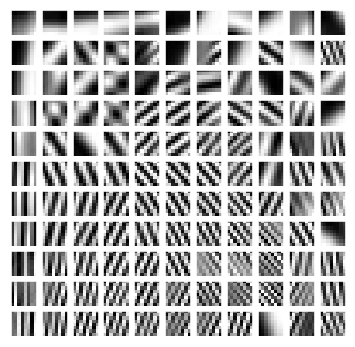

In [253]:
figs, axs = plt.subplots(num,num,figsize=(6,6))
for row in range(num):
    for col in range(num):
        axs[row][col].imshow(A_KSVD_barbara_reshape[:,:,col,row], cmap='gray')
        axs[row][col].set_xticks([])
        axs[row][col].set_yticks([])

In [254]:
X = np.zeros((A_KSVD_barbara.shape[1], y.shape[1]))
for i in range(y.shape[1]):
    X[:, i], _ = OMP(A_KSVD_barbara, y[:, i], k0=4, eps=1e-4)

In [256]:
np.save("barbara_DICT",A_KSVD_barbara)

In [259]:
a = np.load("./barbara_DICT.npy")
a = a.reshape([8,8,11,11])

In [146]:
# img_patchs2 = []
# patch_size = 8
# for row in range(int((im.shape[0] // 8)/2)):
#     for col in range(int((im.shape[1] // 8)/2)):
#         img_patchs2.append(im[row*4:row*4+patch_size, col*4:col*4+patch_size])
# img_patchs2 = np.array(img_patchs2)
img_patchs2 = []
patch_size = 8
step = 2
for row in range(int((im.shape[0] / patch_size * step)) - 2):
    begin_row = int(row * patch_size / step)
    for col in range(int((im.shape[1] / patch_size * step)) - 2):
        begin_col = int(col * patch_size / step)
        img_patchs2.append(im[begin_row:begin_row+patch_size, begin_col:begin_col+patch_size])
img_patchs2 = np.array(img_patchs2)

In [147]:
img_patchs2.shape

(15876, 8, 8)

In [140]:
img_patchs2_re = img_patchs2.reshape(14,14, 64,64)

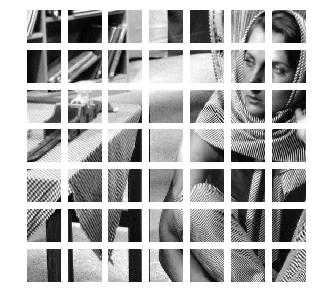

In [141]:
figs, axs = plt.subplots(im.shape[0] // patch_size -1, im.shape[1] // patch_size-1, figsize=(5,5))
for h, himg in enumerate(img_patchs2_re[::2,:,:]):
    for w, wimg in enumerate(himg[::2,:,:]):
        axs[h,w].imshow(wimg, cmap='gray')
        axs[h,w].set_axis_off()

In [142]:
height,width = int(im.shape[0]/patch_size), int(im.shape[1]/patch_size)
img_merge = np.vstack([np.hstack(h_imgs[::2,:,:]) for h_imgs in img_patchs2_re[::2,:,:]])

In [143]:
# height,width = int(im.shape[0]/patch_size), int(im.shape[1]/patch_size)
# # img_patchs2 = img_patchs2.reshape(8,8,64,64)
# img_patchs2 = img_patchs2.reshape(height, width, patch_size, patch_size)
# img_merge = np.vstack([np.hstack(h_imgs) for h_imgs in img_patchs2])

([], <a list of 0 Text yticklabel objects>)

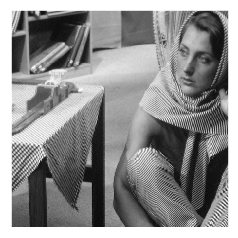

In [145]:
plt.imshow(img_merge, cmap='gray')
plt.xticks([])
plt.yticks([])

In [148]:
y2 = img_patchs2.reshape((-1,64)).swapaxes(0,1)

In [150]:
A_KSVD_barbara = np.load("./barbara_DICT.npy")
X2 = np.zeros((A_KSVD_barbara.shape[1], y2.shape[1]))
for i in range(y2.shape[1]):
    X2[:, i], _ = OMP(A_KSVD_barbara, y2[:, i], k0=4, eps=1e-4)

In [151]:
y2.shape

(64, 15876)

In [152]:
y2_pred = A_KSVD_barbara @ X2

In [154]:
y2_re = y2.reshape( patch_size, patch_size,-1)

In [179]:
def mergeImg(img, height, width, patch_size):
    img = img.reshape( patch_size, patch_size,-1)
    img = img.transpose(2,0,1)
    num = int(np.sqrt(img.shape[0]))
    img = img.reshape(num, num, patch_size, patch_size)
    height,width = int(im.shape[0]/patch_size), int(im.shape[1]/patch_size)
    img_merge = np.vstack([np.hstack(h_imgs[::2,:,:]) for h_imgs in img[::2,:,:]])
    return img_merge

In [183]:
height,width = int(im.shape[0]/patch_size), int(im.shape[1]/patch_size)
img_merge = mergeImg(y2, height, width, patch_size)
img_pred_merge = mergeImg(y2_pred, height, width, patch_size)

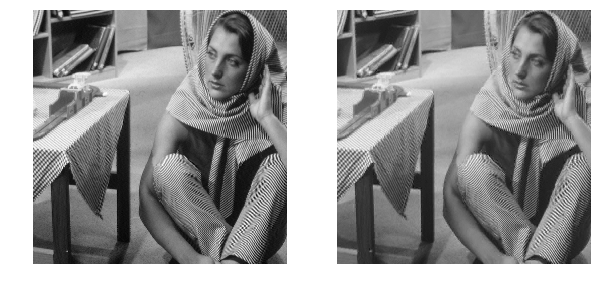

In [190]:
figs, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img_merge, cmap="gray")
axs[1].imshow(img_pred_merge, cmap="gray")
axs[0].set_axis_off()
axs[1].set_axis_off()
# plt.imshow(img_merge, cmap='gray')
# plt.xticks([])
# plt.yticks([])